In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.spatial.distance import cdist
pd.options.mode.chained_assignment = None


In [44]:
'''Load and save functions.'''

filepath = r'scripts/bbb-new'

# load file
def load(fName): 
    f = filepath + "/" + "{}.txt".format(fName)
    return pd.read_csv(f)

# save file
def save(dfName,fName):
    df = dfName
    df.to_csv(filepath + '/' + "{}_NEW.txt".format(fName), sep =',', index=False, float_format="%.6f")
    return print("Saved {}_NEW.txt to {}".format(fName,filepath))

# load GTFS files
trips = load('trips')
stops = load('stops')
stop_times = load('stop_times')
shapes = load('shapes')
routes = load('routes')
# routes.info()

In [41]:
# singleRoute = trips.route_id == 3027
subShapeList = trips.shape_id.unique().tolist()
data = []
for i in subShapeList:
    subShapes = shapes[shapes.shape_id == i]
    
    subTripsList = trips[trips.shape_id == i].trip_id.unique().tolist()
    subTrips = trips[trips.trip_id.isin(subTripsList)]

    subStopTimesList = stop_times.stop_id[stop_times.trip_id.isin(subTripsList)].tolist()

    subStops = stops[stops.stop_id.isin(subStopTimesList)]
#     data.append(i, subTrips)
print(len(subShapes))

64


In [57]:
singleRoute = trips.route_id == 3027
shapeList = trips.shape_id.unique().tolist()
# data = []

subShapes = shapes[shapes.shape_id == 24053]
# subTripsList = trips[trips.shape_id == i].trip_id.unique().tolist()
# subTripsList = trips[singleRoute].trip_id.unique().tolist()
subTripsList = trips[trips.trip_id == 788851].trip_id.tolist()
# subTrips = trips[trips.trip_id.isin(subTripsList)]
subStopTimesList = stop_times.stop_id[stop_times.trip_id.isin(subTripsList)].tolist()
subStops = stops[stops.stop_id.isin(subStopTimesList)]

# turn stops & shapes coords to list, then numpy array
# this will be used for the distance function
stpLat = subStops.stop_lat.tolist()
stpLon = subStops.stop_lon.tolist()
stpCoord = np.array(list(zip(stpLat,stpLon)))

shpLat = subShapes.shape_pt_lat.tolist()
shpLon = subShapes.shape_pt_lon.tolist()
shpCoord = np.array(list(zip(shpLat,shpLon)))

# get distance of each shape point from nearest stop
subShapes['dist_to_stp'] = cdist(shpCoord,stpCoord,'euclidean').min(axis=1) * 10000


# find difference between dist_to_stp rows
subShapes['diff'] = subShapes['dist_to_stp'] - subShapes['dist_to_stp'].shift(1)
# create a dummy column marking where the diff is negative
subShapes['dummy'] = np.where(subShapes['diff'] < 0,1,0)
'''Keep where diff == NaN- this is first shape point and 'should' begin at a stop OR where distance to stop is < 2.8 OR where dummy == 1 AND the the value below it is == 0
AND Keep where dummy == 1 AND distance to stop is < 5 (this may change). This logic will ensure the closest stop is grabbed based on criteria other than spatial criteria. 
The result is a column named "keep" with values of either keep or throw. These values are used later on with a buffer from the stop to highlight the rows to change'''
subShapes['keep'] = np.where(np.logical_or(subShapes['diff'].isna(),\
                                                 np.logical_or(subShapes['dist_to_stp'] < 2.8,\
                                                                np.logical_and(np.logical_and(subShapes['dummy'] == 1, subShapes['dist_to_stp'] < 5.0),\
                                                                               np.logical_and(subShapes['dummy'] == 1, subShapes['dummy'].shift(-1) == 0)\
                                                                              )\
                                                              )\
                                                ) ,'keep','throw')


'''With all of the other parameters above, have a column with a buffer of the stop and check to see if a shape point marked as "keep"
falls within that buffer. If it does, update the shape point lat and lon for that row. There may be more than one shape point moved, inital testng 
has shown this not to be a problem. The generaliztion around the stops "should" not be noticeable. More testing should be done to 100% confirm'''

# create a geodataframe to do an intersection 
intersect_df = gpd.GeoDataFrame(subShapes, geometry = gpd.points_from_xy(subShapes.shape_pt_lon,subShapes.shape_pt_lat))
intersect_df['shape_pt_geometry'] = intersect_df['geometry']
intersect_df.drop(['geometry'],axis=1)

# stop dataframe with a buffer- distance can be adjusted if need be
stopdf = gpd.GeoDataFrame(subStops, geometry=gpd.points_from_xy(subStops.stop_lon,subStops.stop_lat))
stopdf['geometry'] = stopdf.geometry.buffer(.000205)

# intersect df based on buffer polygon
intersect_join = gpd.sjoin(intersect_df,stopdf,how='inner',op='intersects')
# only keep the records 'keep'
intersect_join = intersect_join[(intersect_join.keep == 'keep')]

# create a column to identify the points that were joined
intersect_join['joined'] = 'sure'

# join the intersect df back to the nearest shape df based on index and create the new shapes.txt
badMerge = pd.merge(subShapes,intersect_join,how='left',suffixes=('','_y'),left_index=True,right_index=True)
# got a duplicated index somehow, drop it here
finalMerge = badMerge[~badMerge.index.duplicated()]

# update the new join shape lat lon with stop lat lon based on the 'keep' column
# finalMerge.loc[finalMerge['keep'] == 'keep', 'shape_pt_lat'] = finalMerge['stop_lat']
# finalMerge.loc[finalMerge['keep'] == 'keep', 'shape_pt_lon'] = finalMerge['stop_lon']

# this only works if the alogrithum identified the point as keep, othewise it will just keep the point
finalMerge.loc[(finalMerge['joined'] == 'sure') & (finalMerge['keep'] == 'keep'), 'shape_pt_lat'] = finalMerge['stop_lat']
finalMerge.loc[(finalMerge['joined'] == 'sure' ) & (finalMerge['keep'] == 'keep'), 'shape_pt_lon'] = finalMerge['stop_lon']


# round the lat lon 
finalMerge.round({'shape_pt_lat': 6, 'shape_pt_lon': 6})

# # drop unwanted columns from the final merge df to create the shapes_NEW.txt
# dropCols = [i for i in range(len(finalMerge.columns)) if i > 4]
# finalMerge.drop(finalMerge.columns[dropCols],axis=1,inplace=True)
# finalMerge.info()

#  print the amount of points that were changed
changedPoints = finalMerge.shape_pt_lon != subShapes.shape_pt_lon
percentChanged =  round((len(finalMerge[changedPoints])/len(subShapes) * 100),2)

print('Moved {} shape points ({}%)\n'.format(len(finalMerge[changedPoints]),percentChanged))

# data.append(finalMerge)


# finalMerge = pd.concat(data)
# finalMerge.info()
save(finalMerge,'shapes')

Moved 23 shape points (11.98%)

Saved shapes_NEW.txt to scripts/bbb-new


In [33]:
finalMerge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 192 entries, 20273 to 20464
Data columns (total 5 columns):
shape_id               192 non-null int64
shape_pt_lat           192 non-null float64
shape_pt_lon           192 non-null float64
shape_pt_sequence      192 non-null int64
shape_dist_traveled    192 non-null float64
dtypes: float64(3), int64(2)
memory usage: 14.0 KB


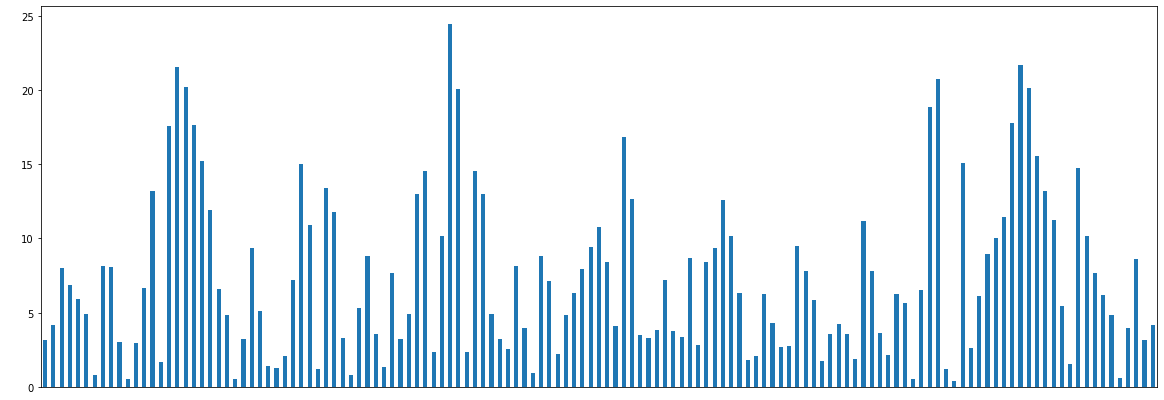

In [46]:
'''Test graph to look at the distances of the shape points in comparison to stops along the route'''
# plot the distance from the stop... the 'valleys' are where the stops are

plt.figure()
plt.ylabel("Distance From Stop").set_color("White")
subShapes['dist_to_stp'].plot(kind='bar',figsize=(20,7)).axes.get_xaxis().set_visible(False)
plt.show()

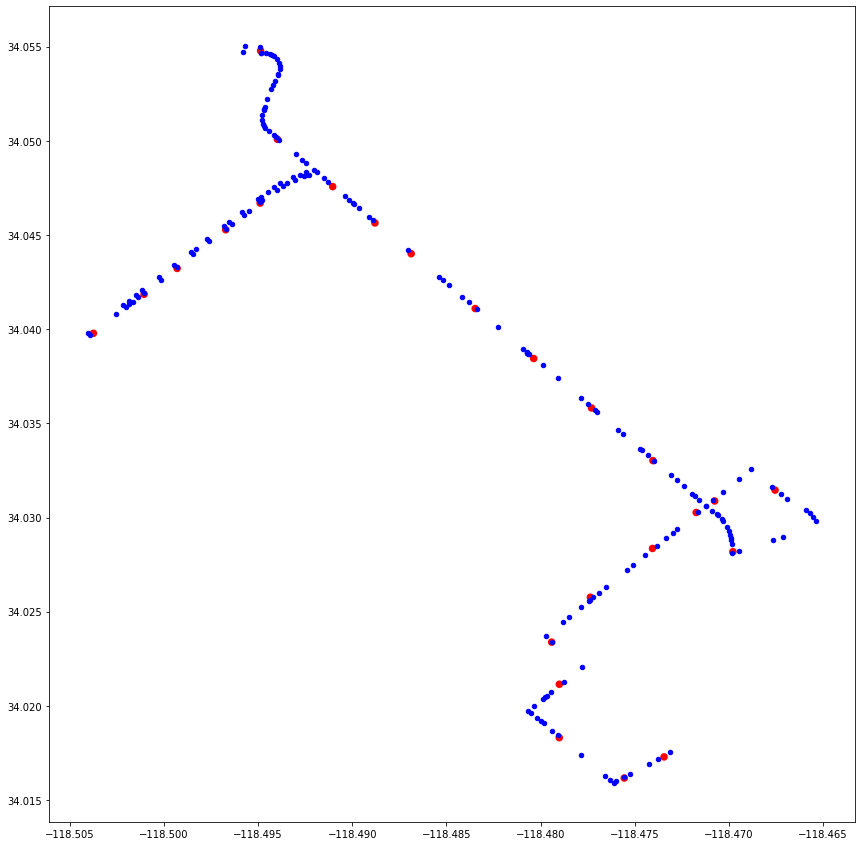

In [46]:
'''Test map (graph) to look at ALL of the shape points for a route in comparison to stops along the route'''
# plot the stops (red) and the shape points the script returns (blue)
# all of the shape points FOR TESTING

wantedShapes = shapes[shapes.shape_id == 24053]
allShapePoints = gpd.GeoDataFrame(wantedShapes, geometry=gpd.points_from_xy(wantedShapes.shape_pt_lon,wantedShapes.shape_pt_lat))
allStopPoints = gpd.GeoDataFrame(subStops, geometry=gpd.points_from_xy(subStops.stop_lon,subStops.stop_lat))
allStopPoints['geometry'] = stopdf.geometry.buffer(.00020)
stopsTest = allStopPoints.plot(figsize=(15,15),color='red')
# allShapePoints.plot(figsize=(15,15),color='blue')
allShapePoints.plot(ax=stopsTest, color='blue',marker='o',markersize=20)
plt.show()

In [105]:
keepOnly = finalMerge[(finalMerge.keep == 'keep')]
keepOnly[keepOnly.dummy == '0']

/home/david/anaconda3/envs/work-gtfs-qa/lib/python3.6/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


,shape_id,shape_pt_lat,shape_pt_lon,shape_pt_sequence,shape_dist_traveled,dist_to_stp,diff,dummy,keep,geometry,...,stop_name,stop_desc,stop_lat,stop_lon,zone_id,stop_url,location_type,parent_station,stop_timezone,wheelchair_boarding


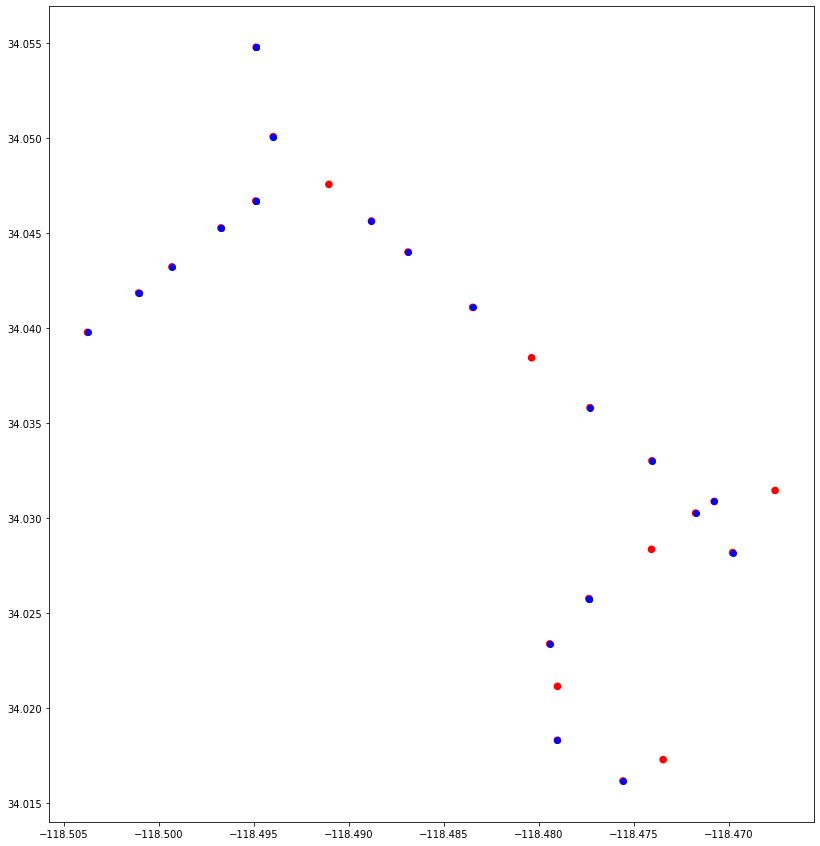

In [51]:
'''Test map (graph) to look at a subset of the shape points identifed as being nearest to stops along the route'''
keepOnly = finalMerge[(finalMerge.joined == 'sure')]
# keepOnly = finalMerge[(finalMerge.keep == 'keep')]
testPointsdf = gpd.GeoDataFrame(keepOnly, geometry=gpd.points_from_xy(keepOnly.shape_pt_lon,keepOnly.shape_pt_lat))
stopdf = gpd.GeoDataFrame(stopdf, geometry=gpd.points_from_xy(stopdf.stop_lon,stopdf.stop_lat))
stopdf['geometry'] = stopdf.geometry.buffer(.00020)


# allShapePoints = gpd.GeoDataFrame(subShapes, geometry=gpd.points_from_xy(subShapes.shape_pt_lon,subShapes.shape_pt_lat))
#plot shape points and stops... see an extra shape point near southern part of route
stopsTest = stopdf.plot(figsize=(15,15),color='red')
testPointsdf.plot(ax=stopsTest, color='blue',marker='o')
# allShapePoints.plot(ax=stopsTest, color='blue',marker='o')

plt.show()
    